In [1]:
import re
import json

from pathlib import Path
from multiprocessing import cpu_count, Manager, Pool

import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm
from matplotlib import pyplot as plt

# Disables no GPU warning
# Comment out to see warning or use GPU
import jax
jax.config.update('jax_platform_name', 'cpu')

from classes.environment import Env

PATH = Path.cwd()

In [2]:
data = pd.read_csv(PATH.joinpath('asset_data', 'TBT_UBT_data_4.csv'), index_col=0)
data.current_state = [('000'+str(cs))[-3:] for cs in data.current_state]
prob = pd.read_csv(PATH.joinpath('asset_data', 'TBT_UBT_transition_matrix.csv'), index_col=0)
prob.index = [('000'+str(idx))[-3:] for idx in prob.index]

with open('intermediate_data/TBT_UBT_9_28_sniper_pairs.json') as json_file:
    pairs_rewards = json.load(json_file)

ordered_rewards = {k: np.mean(v) for k, v in sorted(pairs_rewards.items(), key=lambda item: -item[1])}

In [3]:
entries = 16

top_ten_long = list()
for key in list(ordered_rewards.keys()):
    if len(top_ten_long) == entries//2:
        break
    elif key[2:5] not in top_ten_long:
        top_ten_long.append(key[2:5])
    
for key in list(ordered_rewards.keys())[::-1]:
    if len(top_ten_long) == entries:
        break
    elif key[9:12] not in top_ten_long:
        top_ten_long.append(key[9:12])
    
bottom_ten_short = list()
for key in list(ordered_rewards.keys()):
    if len(bottom_ten_short) == entries//2:
        break
    elif key[9:12] not in bottom_ten_short:
        bottom_ten_short.append(key[9:12])
    
for key in list(ordered_rewards.keys())[::-1]:
    if len(bottom_ten_short) == entries:
        break
    elif key[2:5] not in bottom_ten_short:
        bottom_ten_short.append(key[2:5])
        
print(top_ten_long)
print(bottom_ten_short)

['220', '221', '210', '222', '321', '200', '310', '501', '301', '211', '110', '011', '002', '000', '521', '512']
['302', '301', '221', '300', '312', '321', '412', '311', '212', '320', '200', '322', '501', '500', '002', '422']


In [4]:
for val in top_ten_long:
    if val in bottom_ten_short:
        top_ten_long.remove(val)
        bottom_ten_short.remove(val)
        
for val in bottom_ten_short:
    if val in top_ten_long:
        top_ten_long.remove(val)
        bottom_ten_short.remove(val)
        
print(top_ten_long)
print(bottom_ten_short)

['220', '210', '222', '310', '211', '110', '011', '000', '521', '512']
['302', '300', '312', '412', '311', '212', '320', '322', '500', '422']


In [5]:
all_lists = list()
for len1 in range(1, 7):
    long_states = top_ten_long[:len1]
    for len2 in range(1, 7):
        short_states = bottom_ten_short[:len2]
        all_lists.append((long_states, short_states))

In [6]:
def sniper_list(states_1, states_2, env, start_state):
    state = start_state
    done = False
    all_rewards = list()
    while not done:
        if int(state[0].item()) in states_1:
            state, reward, done, _ = env.step(0)
        elif int(state[0].item()) in states_2:
            state, reward, done, _ = env.step(1)
        else:
            state, reward, done, _ = env.step(2)
        all_rewards.append(reward)
    return all_rewards

In [7]:
def imap_sniper_list(list_of_input_tuples):
    env = Env(data, prob, steps=2000)
    mappings = env.mapping
    
    long = [mappings[s] for s in list_of_input_tuples[0]]
    short = [mappings[s] for s in list_of_input_tuples[1]]
    rewards = list()
    for _ in trange(10, leave=False, position=1):
        rewards.append(sniper_list(long, short, env, env.reset()))
    
    final = np.array(rewards)
    
    strategy_rewards[str(list_of_input_tuples)] = final[:, -1].mean()

In [8]:
num_procs = cpu_count()-1
chunk = 2
print('Number of processes:', num_procs)

procs = list()
manager = Manager()
strategy_rewards = manager.dict()

print('Creating pool')
pool = Pool(processes=num_procs)

print('Start processing')
for _ in tqdm(pool.imap_unordered(imap_sniper_list, all_lists, chunksize=chunk), total=len(all_lists)//chunk):
    pass

strategy_rewards = dict(strategy_rewards)
with open('intermediate_data/TBT_UBT_9_28_selective_sniper.json', 'w') as file:
    json.dump(strategy_rewards, file)

Number of processes: 15
Creating pool
Start processing


In [9]:
try:
    strategy_rewards
except NameError:
    import json
    with open('intermediate_data/TBT_UBT_9_28_selective_sniper.json') as file:
        strategy_rewards = json.load(file)
        
strategy_rewards = {k: v for k, v in sorted(strategy_rewards.items(), key=lambda item: -item[1])}

In [10]:
regex_strategy_list = re.compile(r"\[(('\d*',\s)*'\d*')\]")
regex_strategy = re.compile(r"\d+")

[]

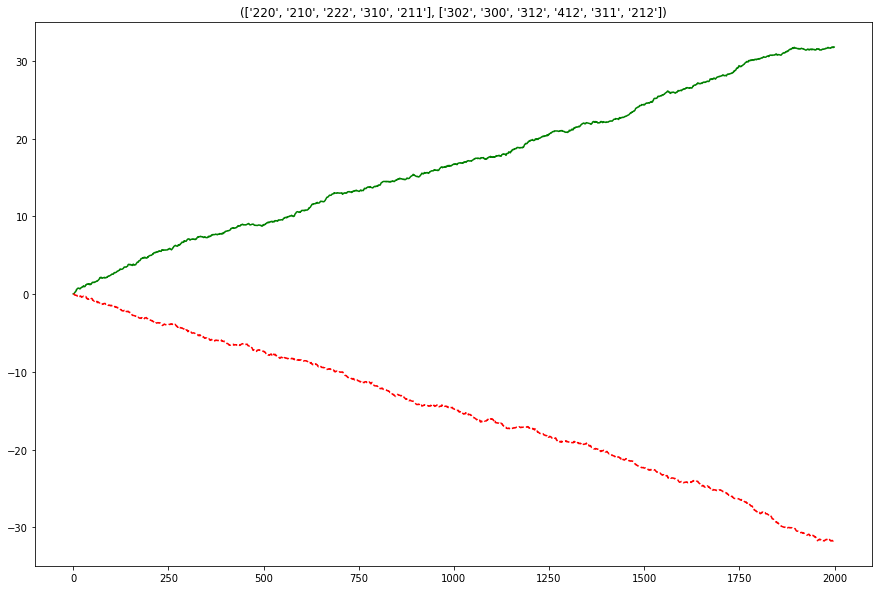

In [11]:
key = list(strategy_rewards.keys())[0]
long_short_list = regex_strategy_list.findall(key)
long = regex_strategy.findall(long_short_list[0][0])
short = regex_strategy.findall(long_short_list[1][0])

env = Env(data, prob, steps=2000)
mappings = env.mapping

long_mapped = [mappings[s] for s in long]
short_mapped = [mappings[s] for s in short]

plt.figure(figsize=(15, 10))

rewards1 = np.array([sniper_list(long_mapped, short_mapped, env, env.reset()) for _ in range(10)])
rewards2 = np.array([sniper_list(short_mapped, long_mapped, env, env.reset()) for _ in range(10)])

plt.plot(rewards1.mean(axis=0), 'g-')
plt.plot(rewards2.mean(axis=0), 'r--')
    
plt.title(f'({long}, {short})')
plt.plot()

[]

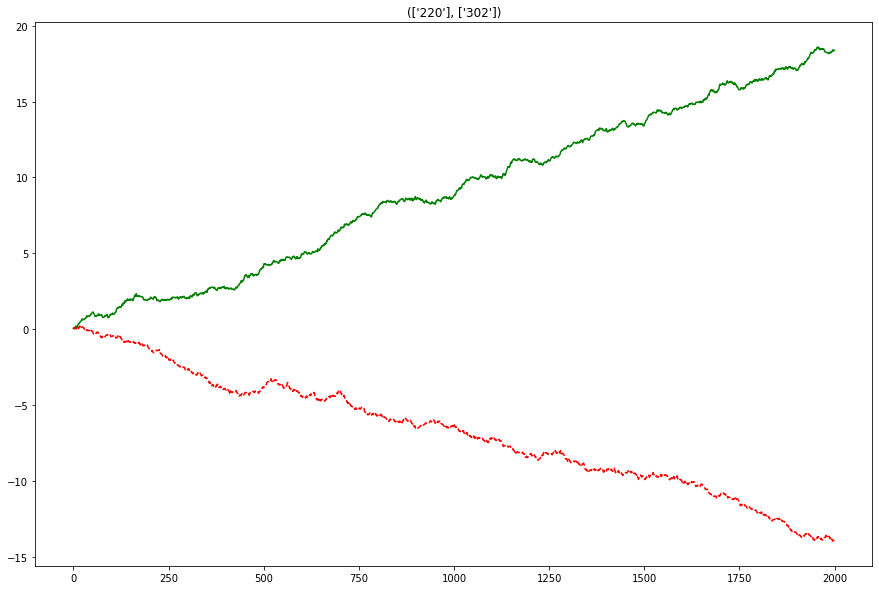

In [12]:
key = list(strategy_rewards.keys())[-1]
long_short_list = regex_strategy_list.findall(key)
long = regex_strategy.findall(long_short_list[0][0])
short = regex_strategy.findall(long_short_list[1][0])

env = Env(data, prob, steps=2000)
mappings = env.mapping

long_mapped = [mappings[s] for s in long]
short_mapped = [mappings[s] for s in short]

plt.figure(figsize=(15, 10))

rewards1 = np.array([sniper_list(long_mapped, short_mapped, env, env.reset()) for _ in range(10)])
rewards2 = np.array([sniper_list(short_mapped, long_mapped, env, env.reset()) for _ in range(10)])

plt.plot(rewards1.mean(axis=0), 'g-')
plt.plot(rewards2.mean(axis=0), 'r--')
    
plt.title(f'({long}, {short})')
plt.plot()